<a href="https://www.kaggle.com/code/harshris21/vision-transformer-scratch?scriptVersionId=126741999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00


In [5]:
!pip install torchsummary

In [11]:
import torch 
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image 
import torch.nn.functional as F 
from torchvision.transforms import Compose,Resize,ToTensor 
from torchsummary import summary
from einops.layers.torch import Rearrange,Reduce
from einops import rearrange,reduce,repeat 

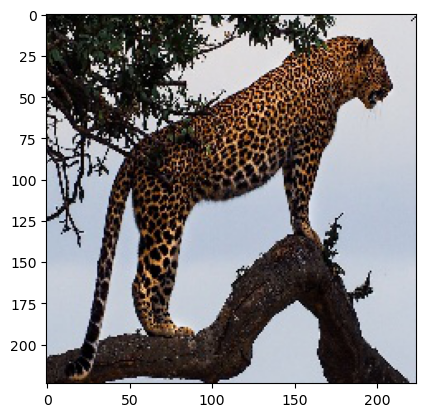

In [8]:
img=Image.open('/kaggle/input/cats-in-the-wild-image-classification/train/AFRICAN LEOPARD/001.jpg')

fig=plt.figure()
plt.imshow(img)

In [9]:
#resize this to imagenet dimension 

transform=Compose([Resize((224,224)),ToTensor()])
x=transform(img)
x=x.unsqueeze(0)


In [10]:
x.shape

torch.Size([1, 3, 224, 224])

In [14]:
#let's create patches of the image 

patch_size=16 #16 pixels 
patches=rearrange(x,'b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1=patch_size,s2=patch_size)
# pathes = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)

In [20]:
import torch.nn as nn

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(self,in_channel:int=3,patch_size=16,embed_size=768):
        super().__init__()
        #embed_size=patch_size*patch_size*in_channel
        self.projection=nn.Sequential(
                                    Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)',s1=patch_size,s2=patch_size),
                                    nn.Linear(patch_size*patch_size*in_channels,emb_size))

    def forward(self,x):
        x=self.projection(x)
        return x 

In [29]:
#original paper uses conv2d instead of Linear for Perfomance Gain 
from torch import Tensor
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels:int=3,patch_size:int=16,embed_size:int=768):
        super().__init__()
        self.projection=nn.Sequential(
                        nn.Conv2d(in_channels,out_channels=embed_size,kernel_size=patch_size,stride=patch_size),
                        Rearrange('b e (h) (w) -> b (h w) e')
                        )
            
    def forward(self, x: Tensor) -> Tensor:
        x=self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [42]:
##adding CLS Token

#original paper uses conv2d instead of Linear for Perfomance Gain 
from torch import Tensor
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels:int=3,patch_size:int=16,embed_size:int=768):
        super().__init__()
        self.projection=nn.Sequential(
                        nn.Conv2d(in_channels,out_channels=embed_size,kernel_size=patch_size,stride=patch_size),
                        Rearrange('b e (h) (w) -> b (h w) e')
                        )
        self.cls_token=nn.Parameter(torch.randn(1,1, embed_size))
            
    def forward(self, x: Tensor) -> Tensor:
        b=x.shape[0]
        x=self.projection(x)
#         cls_tokens=repeat(self.cls_token,'() n e -> b n e',b=b)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        print(cls_tokens.shape)
        x=torch.cat([cls_tokens,x],dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 1, 768])


torch.Size([1, 197, 768])

In [46]:
###adding positional encoding/embedding

##adding CLS Token

#original paper uses conv2d instead of Linear for Perfomance Gain 
from torch import Tensor
class PatchEmbedding(nn.Module):
    def __init__(self,in_channels:int=3,patch_size:int=16,embed_size:int=768,img_size:int=224):
        super().__init__()
        self.projection=nn.Sequential(
                        nn.Conv2d(in_channels,out_channels=embed_size,kernel_size=patch_size,stride=patch_size),
                        Rearrange('b e (h) (w) -> b (h w) e')
                        )
        self.cls_token=nn.Parameter(torch.randn(1,1, embed_size))
        self.positions=nn.Parameter(torch.randn((img_size//patch_size)**2+1,embed_size))
            
    def forward(self, x: Tensor) -> Tensor:
        b=x.shape[0]
        x=self.projection(x)
#         cls_tokens=repeat(self.cls_token,'() n e -> b n e',b=b)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        print(cls_tokens.shape)
        x=torch.cat([cls_tokens,x],dim=1)
        x+=self.positions
        print(x.shape)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 1, 768])
torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

In [47]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 512, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [48]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [49]:

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [50]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [52]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 1, 768])
torch.Size([1, 197, 768])


torch.Size([1, 197, 768])

In [53]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

In [54]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [55]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [56]:
s   

torch.Size([2, 1, 768])
torch.Size([2, 197, 768])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]     

In [31]:
s=nn.Parameter(torch.randn(1,1, 768))

In [33]:
s.shape

torch.Size([1, 1, 768])